[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nahuelalmeira/midnight/blob/main/notebooks/notebook.ipynb)

In [ ]:
!pip install --quiet git+https://github.com/nahuelalmeira/midnight

In [1]:
# Graphics
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

sns.set()
sns.set_context("talk")
matplotlib.rcParams["figure.figsize"] = (12, 8)

In [2]:
from midnight.player import Player
from midnight.game import Game
from midnight.strategy import (
    ConservativeStrategy,
    MiddleStrategy,
    AlwaysConservativeStrategy,
    AlwaysMiddleStrategy,
)

In [3]:
sample_conservative = pd.Series(ConservativeStrategy.sample(100000))
sample_middle = pd.Series(MiddleStrategy.sample(100000))
samples = {"Conservative": sample_conservative, "Middle": sample_middle}

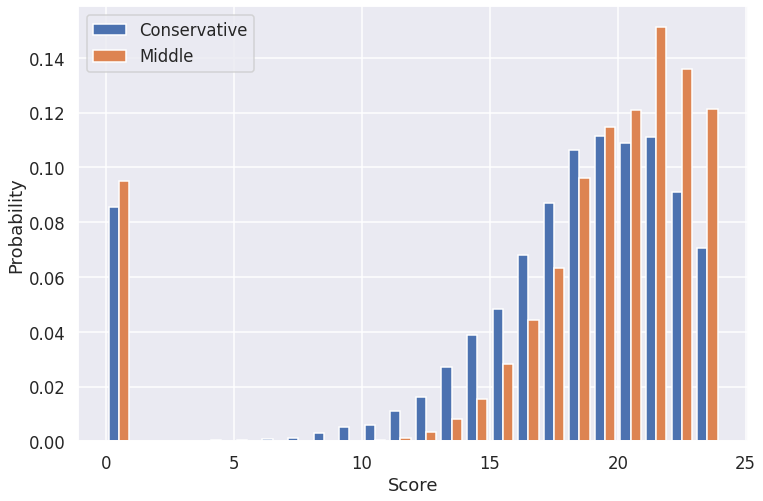

In [4]:
fig, ax = plt.subplots()
ax.set_xlabel("Score")
ax.set_ylabel("Probability")
ax.hist(samples.values(), bins=range(0, 25), density=True, label=list(samples.keys()))
plt.legend()
plt.show()

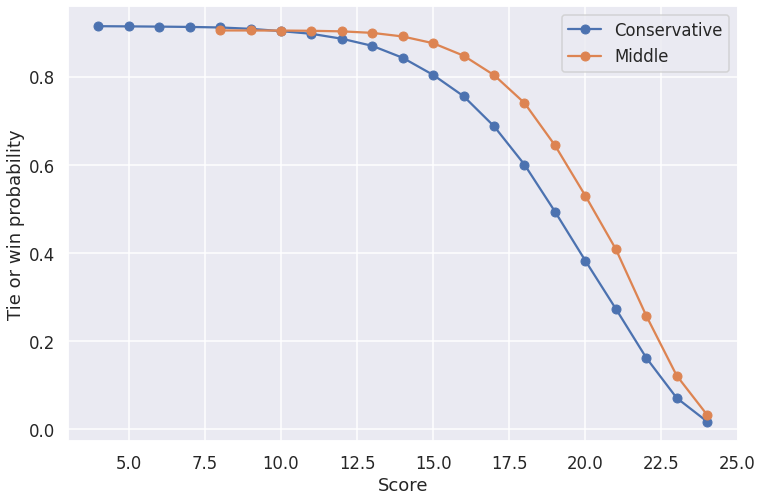

In [5]:
fig, ax = plt.subplots()
for name, sample in samples.items():
    (
        sample.value_counts(normalize=True)
        .sort_index(ascending=False)
        .drop(0)
        .cumsum()
        .plot(marker="o", xlabel="Score", ylabel="Tie or win probability", label=name, ax=ax)
    )
ax.legend()
plt.show()

In [6]:
n_rounds = 10000
n_players = 2
initial_stake = 1000

print("-----------------")
print("Game settings")
print(f"Number of players: {n_players}")
print(f"Number of rounds: {n_rounds}")
print(f"Initial stake: {initial_stake}")
print("-----------------")
print()

Player.reset_counter()
game = Game(n_rounds=n_rounds)
player1 = Player(
    strategy=AlwaysConservativeStrategy(), initial_stake=initial_stake
)
game.add_player(player1)
player2 = Player(
    strategy=AlwaysMiddleStrategy(), initial_stake=initial_stake
)
game.add_player(player2)

# Play game
game.play()

print("-----------------")
print("Game stats")
stats = game.get_game_stats()
display(stats.head(10))
print("-----------------")
print()
print(f"Final relative stakes: {game.relative_stakes}")
print()

print("-----------------")
print("Scores")
scores = game.get_all_scores()
display(scores.head())
print("-----------------")
print()

print("-----------------")
print("Qualification rate per player:")
display((scores > 0).mean())
print("-----------------")
print()

print("-----------------")
print("Win rate per player:")
display(stats["WINNER"].value_counts(normalize=True))
print("-----------------")
print()


-----------------
Game settings
Number of players: 2
Number of rounds: 10000
Initial stake: 1000
-----------------

-----------------
Game stats


,ROUND,POT,WINNER,SCORES
0,0,2,Player2,"[18, 21]"
1,1,2,Player2,"[19, 23]"
2,2,2,Player2,"[19, 20]"
3,3,2,Player2,"[20, 21]"
4,4,2,Player1,"[19, 17]"
5,5,2,Tie,"[19, 19]"
6,6,5,Player1,"[14, 0]"
7,7,2,Player2,"[18, 22]"
8,8,2,Player2,"[10, 17]"
9,9,2,Tie,"[21, 21]"


-----------------

Final relative stakes: [-1992, 1992]

-----------------
Scores


,Player1,Player2
0,18,21
1,19,23
2,19,20
3,20,21
4,19,17


-----------------

-----------------
Qualification rate per player:


Player1    0.9128
Player2    0.9069
dtype: float64

-----------------

-----------------
Win rate per player:


Player2    0.5485
Player1    0.3626
Tie        0.0889
Name: WINNER, dtype: float64

-----------------

